In [3]:
import nibabel as nib
import numpy as np
import random
import os
"""
packages that does conventional model fitting
"""
import amico
"""
packages that generate train/test dataset
"""
from FormatData import generate_data, parser as data_parser
"""
packages that produce the rejection shceme
"""
from filter_qa import parser as filter_parser, load_eddy, order_volumes
"""
package to store the intermediate result
"""
import pickle
"""
package to work out RMSE and SSIM
"""
from utils import calc_RMSE, calc_ssim, load_nii_image, filter_mask, show_slices


2022-07-25 10:43:13.693664: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [ ]:
class Namespace:
    """
    a class generate parser for cmd line args
    """
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [ ]:
# s04 data repo
s04_path = '/home/vw/Data/IndividualProject/MedICSS2021_/Data-NODDI/s03_still_reg/'
s04_motion_path = '/home/vw/Data/IndividualProject/MedICSS2021_/Data-NODDI/s03_motion/'
s04_NDI_path = os.path.join(s04_path, 's03_still_reg_NDI.nii')
s04_ODI_path = os.path.join(s04_path, 's03_still_reg_ODI.nii')
s04_FWF_path = os.path.join(s04_path, 's03_still_reg_FWF.nii')

In [ ]:
filter_mask(s04_path, s04_FWF_path)

In [ ]:
filter_mask(s04_motion_path, s04_FWF_path)

In [ ]:
s04_mask_path = os.path.join(s04_path, 'filtered_mask.nii')
s04_motion_mask_path = os.path.join(s04_motion_path, 'filtered_mask.nii')

In [ ]:
s04_mask = load_nii_image(s04_mask_path)
s04_motion_mask = load_nii_image(s04_motion_mask_path)

In [ ]:
# load the truth data for subject 3
# s04_NDI_img = nib.load(s04_NDI_path)
# s04_ODI_img = nib.load(s04_NDI_path)
# s04_FWF_img = nib.load(s04_NDI_path)
# s04_NDI_affine = s04_NDI_img.affine
# s04_ODI_affine = s04_ODI_img.affine
# s04_FWF_affine = s04_FWF_img.affine
s04_NDI_img_data = load_nii_image(s04_NDI_path, s04_mask)
s04_ODI_img_data = load_nii_image(s04_ODI_path, s04_mask)
s04_FWF_img_data = load_nii_image(s04_FWF_path, s04_mask)

In [ ]:
print(s04_NDI_img_data.shape)

----------
Auxilary functions for AMICO

In [ ]:
def writefile(path, file, combine, savename):
    with open(path+savename, 'w') as fout:
        read_path = path+file
        read_file = open(read_path, 'r')
        lines = read_file.readlines()
        for line in lines:
            temp = line.split()
            temp = [e for e, b in zip(temp, combine) if b == 1]
            fout.write(' '.join(e for e in temp))
            fout.write('\n')
    fout.close()
    # 1,3,8
    # combine = [1,0,1,]

def writediffusion(path, file, combine, savename):
    img = nib.load(path+file)
    data = img.get_fdata()
    data = data[..., combine==1]
    img = nib.Nifti1Image(data, np.eye(4))
    nib.save(img, path+savename)

In [ ]:
def run_amico(subject_path, diffusion, bvals, bvecs, suffix):
    # run amico
    amico.setup()
    # generate a scheme file from the bvals/bvecs files as follows, using the remained bvals and bvecs. Because data rejection is applied
    amico.util.fsl2scheme(subject_path+bvals, subject_path+bvecs)
    ae = amico.Evaluation("/home/vw/Data/IndividualProject/MedICSS2021_/Data-NODDI", subject_path.split('/')[-2], verbose=0)
    # load the data
    ae.load_data(dwi_filename = diffusion, scheme_filename = bvals+'.scheme', mask_filename = "filtered_mask.nii", b0_thr = 0)
    # Set model for NODDI and generate the response functions for all the compartments:
    ae.set_model("NODDI")
    ae.generate_kernels(regenerate=True)
    ae.load_kernels()
    # model fit.
    ae.fit()
    # ICVF = NDI
    # ISOVF = FWF
    # OD = ODI
    ae.save_results(path_suffix=suffix)

--------------
AMICO over s04 motion data:

In [ ]:
s04_motion_path = '/home/vw/Data/IndividualProject/MedICSS2021_/Data-NODDI/s03_motion/'

1. full volume of s03 motion data

In [ ]:
combine = np.ones(96, dtype=np.int8)
writefile(s04_motion_path, 'bvals', combine, savename='full_bvals')
writefile(s04_motion_path, 'bvecs', combine, savename='full_bvecs')
writediffusion(s04_motion_path, 'diffusion.nii', combine, savename='full_diffusion')

In [ ]:
# run amico
run_amico(s04_motion_path, 'full_diffusion.nii', 'full_bvals', 'full_bvecs', 'full_volume')

In [ ]:
# get the saved results
icvf_path = '/home/vw/Data/IndividualProject/MedICSS2021_/Data-NODDI/s03_motion/AMICO/NODDI_full_volume/FIT_ICVF.nii.gz'
isovf_path = '/home/vw/Data/IndividualProject/MedICSS2021_/Data-NODDI/s03_motion/AMICO/NODDI_full_volume/FIT_ISOVF.nii.gz'
od_path = '/home/vw/Data/IndividualProject/MedICSS2021_/Data-NODDI/s03_motion/AMICO/NODDI_full_volume/FIT_OD.nii.gz'

# icvf_img = nib.load(icvf_path)
# icvf = icvf_img.get_fdata()
# isovf_img = nib.load(isovf_path)
# isovf = isovf_img.get_fdata()
# od_img = nib.load(od_path)
# od = od_img.get_fdata()
icvf = load_nii_image(icvf_path, s04_mask)
isovf = load_nii_image(isovf_path, s04_mask)
od = load_nii_image(od_path, s04_mask)

In [ ]:
# analyze the saved results: rmse and ssim
ndi_rmse = np.sqrt(((icvf-s04_NDI_img_data)**2).mean())
odi_rmse = np.sqrt(((od-s04_ODI_img_data)**2).mean())
fwf_rmse = np.sqrt(((isovf-s04_FWF_img_data)**2).mean())
print(ndi_rmse, odi_rmse, fwf_rmse)
RMSE = (ndi_rmse, odi_rmse, fwf_rmse)

# ndi_ssim = calc_ssim(icvf, s04_NDI_img_data)
# odi_ssim = calc_ssim(od, s04_ODI_img_data)
# fwf_ssim = calc_ssim(isovf, s04_FWF_img_data)
# print(ndi_ssim, odi_ssim, fwf_ssim)
# SSIM = (ndi_ssim, odi_ssim, fwf_ssim)

In [ ]:
path = '/home/vw/Data/IndividualProject/MedICSS2021_/Net/new_exp1_results/s3/motion_AMICO'

with open(os.path.join(path, 's03_96_rmse.pickle'), 'wb') as f:
    pickle.dump(RMSE, f)
# with open(os.path.join(path, 's03_96_ssim.pickle'), 'wb') as f:
#     pickle.dump(SSIM, f)

2. Progressively add motion-corrupted data into the training sample for AMICO

In [ ]:
# use the stringnet threshold to filter off data
t0, t1, r0, r1, out, num = 3.0, 2.0, 3.0, 2.0, 0.05, 96

filter_cmd = '--path ' + s04_motion_path + ' --t0 ' + str(t0) + ' --t1 ' + str(t1) + ' --r0 ' + str(r0) + ' --r1 ' + str(r1) + ' --out ' + str(out) + ' --num ' + str(num)
filter_args = filter_parser().parse_args(filter_cmd.split())
sorted_index = order_volumes(filter_args)
sorted_index

In [ ]:
movefile = open('/home/vw/Data/IndividualProject/MedICSS2021_/Data-NODDI/s03_motion/move_t0-3.0_t1-2.0_r0-3.0_r1-2.0_out-0.05.txt', 'r')
combine = np.array([int(num) for num in movefile.readline().split(' ')[:-1]])

In [ ]:
selected_indices = np.where(combine==1)[0]
selected_indices

In [ ]:
set(sorted_index[:len(selected_indices)]).difference(set(selected_indices))

In [ ]:
# get the indices of unselected volumes
unselected_indices = np.where(combine==0)[0]
unselected_indices

In [ ]:
s4_bvals = '0 3000 1000 2000 2000 1000 2000 3000 1000 2000 3000 1000 2000 3000 1000 2000 3000 0 1000 3000 2000 1000 2000 3000 1000 2000 3000 1000 2000 3000 1000 2000 3000 0 1000 3000 2000 1000 1000 2000 3000 2000 3000 1000 2000 3000 1000 2000 3000 0 1000 2000 3000 1000 2000 3000 1000 2000 3000 1000 2000 3000 2000 1000 3000 0 1000 3000 2000 3000 1000 2000 1000 2000 3000 3000 1000 2000 1000 2000 3000 0 1000 3000 2000 1000 2000 2000 1000 3000 3000 1000 2000 3000 3000 1000'
s4_bvals = s4_bvals.split()
s4_bvals[3]
# I have checked that the first 8 volume in the sorted index has at least three different b vals.

In [ ]:
for i in range(8,len(sorted_index),3):
    combine = np.zeros(len(sorted_index), dtype=np.int8)
    for index in sorted_index[:i]:
        combine[index] = 1
    selected_vols = str(i)
    # name of the files
    suffix = selected_vols+'_volume'
    bvals = selected_vols+'_bvals'
    bvecs = selected_vols+'_bvecs'
    diffusion = selected_vols+'_diffusion'
    # write files
    writefile(s04_motion_path, 'bvals', combine, bvals)
    writefile(s04_motion_path, 'bvecs', combine, bvecs)
    writediffusion(s04_motion_path, 'diffusion.nii', combine, diffusion)
    # run amico
    run_amico(s04_motion_path, diffusion+'.nii', bvals, bvecs, suffix=suffix)
    # analyze
    icvf_path = '/home/vw/Data/IndividualProject/MedICSS2021_/Data-NODDI/s03_motion/AMICO/NODDI_'+suffix+'/FIT_ICVF.nii.gz'
    isovf_path = '/home/vw/Data/IndividualProject/MedICSS2021_/Data-NODDI/s03_motion/AMICO/NODDI_'+suffix+'/FIT_ISOVF.nii.gz'
    od_path = '/home/vw/Data/IndividualProject/MedICSS2021_/Data-NODDI/s03_motion/AMICO/NODDI_'+suffix+'/FIT_OD.nii.gz'

    icvf = load_nii_image(icvf_path, s04_mask)
    od = load_nii_image(od_path, s04_mask)
    isovf = load_nii_image(isovf_path, s04_mask)

    
    ndi_rmse = np.sqrt(((s04_NDI_img_data-icvf)**2).mean())
    odi_rmse = np.sqrt(((s04_ODI_img_data-od)**2).mean())
    fwf_rmse = np.sqrt(((s04_FWF_img_data-isovf)**2).mean())
    RMSE = (ndi_rmse, odi_rmse, fwf_rmse)
    print(RMSE)
    print(np.average(RMSE))

    
    # ndi_ssim = calc_ssim(icvf, s03_NDI_img_data)
    # odi_ssim = calc_ssim(od, s03_ODI_img_data)
    # fwf_ssim = calc_ssim(isovf, s03_FWF_img_data)
    # ssim = (ndi_ssim, odi_ssim, fwf_ssim)

    path = '/home/vw/Data/IndividualProject/MedICSS2021_/Net/new_exp1_results/s3/motion_AMICO'

    with open(os.path.join(path, 's03_'+selected_vols+'_rmse.pickle'), 'wb') as f:
        pickle.dump(RMSE, f)
    # with open(os.path.join(path, 's03_'+selected_vols+'_ssim.pickle'), 'wb') as f:
    #     pickle.dump(ssim, f)

---------
run with CNN

In [ ]:
"""
packages that trains network
"""
from Training import train_network
from utils.model import parser as model_parser
"""
packages that test network
"""
from Testing import test_model

In [ ]:
# hyperparameters for the networks
layers = 4 # the number of hidden layers; this is the optimal number of layer
lr = 0.0001 # the learning rate
patch_size = 3 # the size of patches for 2D and 3D CNN
batch = 256 # the batch size
epoch = 100 # the number of epoches for training

# we firstly study subject s02, use s01 as a seperate training dataset
study_subject = 's03_still_reg' # the subject we want to study
sep_train_subject = 's01_still' # this is separate training candidate
model = 'conv3d'
ltype = 'A'

In [ ]:
import matplotlib.pyplot as plt
def plot_loss(cmd):
    """
    A function that used to plot the loss curve for the trained network.
    Args:
        cmd: String, the command line in the terminal
    """
    args = model_parser().parse_args(cmd.split())
    history = train_network(args)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Generate data

In [ ]:
"""
Generate the base dataset for s04_motion first for all NODDI parameters.
"""
cmd = "--base --label_type A --subjects s03_still_reg --path /home/vw/Data/IndividualProject/MedICSS2021_/Data-NODDI"
args = data_parser().parse_args(cmd.split())
generate_data(args)

In [ ]:
cnn3ddata_cmd = '--subjects s03_still_reg' + ' --label_type ' + ltype + ' --' + model
cnn3ddata_args  = data_parser().parse_args(cnn3ddata_cmd.split())
generate_data(cnn3ddata_args)

In [ ]:
# use the stringnet threshold to filter off data
t0, t1, r0, r1, out, num = 3.0, 2.0, 3.0, 2.0, 0.05, 96

filter_cmd = '--path ' + s04_motion_path + ' --t0 ' + str(t0) + ' --t1 ' + str(t1) + ' --r0 ' + str(r0) + ' --r1 ' + str(r1) + ' --out ' + str(out) + ' --num ' + str(num)
filter_args = filter_parser().parse_args(filter_cmd.split())
sorted_index = order_volumes(filter_args)
sorted_index

Training Starts here:

In [ ]:
for i in range(8,len(sorted_index),3):
    combine = np.zeros(len(sorted_index), dtype=np.int8)
    for index in sorted_index[:i]:
        combine[index] = 1
    selected_vols = str(i)

    movefile = ' '.join(map(str, combine))

    cnntrain_cmd = '--train_subjects ' + sep_train_subject + ' --model ' + model + ' --layer ' + str(layers) + ' --label_type ' + ltype + ' --lr ' + str(lr) + ' --batch ' + str(batch) + ' --patch_size ' + str(patch_size)\
               + ' --epoch ' + str(epoch) + ' --movefile ' + movefile + ' --train'
    plot_loss(cnntrain_cmd)
    # Testing
    cnntest_cmd = '--test_subjects ' + study_subject + ' --model ' + model + ' --layer ' + str(layers) + ' --label_type ' + ltype + ' --movefile ' + movefile
    cnntest_args = model_parser().parse_args(cnntest_cmd.split())
    rmse, ssim = test_model(cnntest_args)

    # save the result
    path = '/home/vw/Data/IndividualProject/MedICSS2021_/Net/new_exp1_results/s3/motion_free_CNN'

    with open(os.path.join(path, 's03_'+selected_vols+'_rmse.pickle'), 'wb') as f:
        pickle.dump(rmse, f)
    # with open(os.path.join(path, 's03_'+selected_vols+'_ssim.pickle'), 'wb') as f:
    #     pickle.dump(ssim, f)
    

In [ ]:
# Train CNN by using all volumes
combine = np.ones(96, dtype=np.int8)
movefile = ' '.join(map(str, combine))

print(sep_train_subject, model, layers, ltype, lr, batch, patch_size, epoch)

cnntrain_cmd = '--train_subjects ' + 's01_still' + ' --model ' + model + ' --layer ' + str(layers) + ' --label_type ' + ltype + ' --lr ' + str(lr) + ' --batch ' + str(batch) + ' --patch_size ' + str(patch_size)\
            + ' --epoch ' + str(epoch) + ' --movefile ' + movefile + ' --train'
plot_loss(cnntrain_cmd)

In [ ]:
print(study_subject, model, layers, ltype)
cnn3dtest_cmd = '--test_subjects ' + 's03_still_reg' + ' --model ' + model + ' --layer ' + str(layers) + ' --label_type ' + ltype
cnn3dtest_args = model_parser().parse_args(cnn3dtest_cmd.split())
# test
rmse, ssim = test_model(cnn3dtest_args)

In [ ]:
with open(os.path.join(path, 's03_96_rmse.pickle'), 'wb') as f:
    pickle.dump(rmse, f)

-----
AMICO on motion-free data

In [ ]:
s04_free_path = '/home/vw/Data/IndividualProject/MedICSS2021_/Data-NODDI/s03_still_reg/'

1. full volume of s03 motion free data

In [ ]:
combine = np.ones(96, dtype=np.int8)
writefile(s04_free_path, 'bvals', combine, savename='full_bvals')
writefile(s04_free_path, 'bvecs', combine, savename='full_bvecs')
writediffusion(s04_free_path, 'diffusion.nii', combine, savename='full_diffusion')

In [ ]:
# run amico
run_amico(s04_free_path, 'full_diffusion.nii', 'full_bvals', 'full_bvecs', 'full_volume')

In [ ]:
# get the saved results
icvf_path = os.path.join(s04_free_path, 'AMICO/NODDI_full_volume/FIT_ICVF.nii.gz')
isovf_path = os.path.join(s04_free_path, 'AMICO/NODDI_full_volume/FIT_ISOVF.nii.gz')
od_path = os.path.join(s04_free_path, 'AMICO/NODDI_full_volume/FIT_OD.nii.gz')

# icvf_img = nib.load(icvf_path)
# icvf = icvf_img.get_fdata()
# isovf_img = nib.load(isovf_path)
# isovf = isovf_img.get_fdata()
# od_img = nib.load(od_path)
# od = od_img.get_fdata()
icvf = load_nii_image(icvf_path, s04_mask)
od = load_nii_image(od_path, s04_mask)
isovf = load_nii_image(isovf_path, s04_mask)

In [ ]:
# analyze the saved results: rmse and ssim
# ndi_rmse = calc_RMSE(icvf, s04_NDI_img_data, s04_mask)
# odi_rmse = calc_RMSE(od, s04_ODI_img_data, s04_mask)
# fwf_rmse = calc_RMSE(isovf, s04_FWF_img_data, s04_mask)
# print(ndi_rmse, odi_rmse, fwf_rmse)
# RMSE = (ndi_rmse, odi_rmse, fwf_rmse)

ndi_rmse = np.sqrt(((s04_NDI_img_data-icvf)**2).mean())
odi_rmse = np.sqrt(((s04_ODI_img_data-od)**2).mean())
fwf_rmse = np.sqrt(((s04_FWF_img_data-isovf)**2).mean())
RMSE = (ndi_rmse, odi_rmse, fwf_rmse)
print(RMSE)
print(np.average(RMSE))

# ndi_ssim = calc_ssim(icvf, s03_NDI_img_data)
# odi_ssim = calc_ssim(od, s03_ODI_img_data)
# fwf_ssim = calc_ssim(isovf, s03_FWF_img_data)
# print(ndi_ssim, odi_ssim, fwf_ssim)
# SSIM = (ndi_ssim, odi_ssim, fwf_ssim)

In [ ]:
path = '/home/vw/Data/IndividualProject/MedICSS2021_/Net/new_exp1_results/s3/motion_free_AMICO'

with open(os.path.join(path, 's03_96_rmse.pickle'), 'wb') as f:
    pickle.dump(RMSE, f)
# with open(os.path.join(path, 's03_motion_free_96_ssim.pickle'), 'wb') as f:
#     pickle.dump(SSIM, f)

2. Progressively add motion-corrupted data into the training sample for AMICO

In [ ]:
# use the stringnet threshold to filter off data
t0, t1, r0, r1, out, num = 3.0, 2.0, 3.0, 2.0, 0.05, 96

filter_cmd = '--path ' + s04_motion_path + ' --t0 ' + str(t0) + ' --t1 ' + str(t1) + ' --r0 ' + str(r0) + ' --r1 ' + str(r1) + ' --out ' + str(out) + ' --num ' + str(num)
filter_args = filter_parser().parse_args(filter_cmd.split())
sorted_index = order_volumes(filter_args)
sorted_index

In [ ]:
for i in range(8,len(sorted_index),3):
    combine = np.zeros(len(sorted_index), dtype=np.int8)
    for index in sorted_index[:i]:
        combine[index] = 1
    selected_vols = str(i)
    # name of the files
    suffix = selected_vols+'_volume'
    bvals = selected_vols+'_bvals'
    bvecs = selected_vols+'_bvecs'
    diffusion = selected_vols+'_diffusion'
    # write files
    writefile(s04_free_path, 'bvals', combine, bvals)
    writefile(s04_free_path, 'bvecs', combine, bvecs)
    writediffusion(s04_free_path, 'diffusion.nii', combine, diffusion)
    # run amico
    run_amico(s04_free_path, diffusion+'.nii', bvals, bvecs, suffix=suffix)
    # analyze
    icvf_path = os.path.join(s04_free_path, 'AMICO/NODDI_'+suffix+'/FIT_ICVF.nii.gz')
    isovf_path = os.path.join(s04_free_path, 'AMICO/NODDI_'+suffix+'/FIT_ISOVF.nii.gz')
    od_path = os.path.join(s04_free_path, 'AMICO/NODDI_'+suffix+'/FIT_OD.nii.gz')

    icvf = load_nii_image(icvf_path, s04_mask)
    od = load_nii_image(od_path, s04_mask)
    isovf = load_nii_image(isovf_path, s04_mask)

    
    ndi_rmse = np.sqrt(((s04_NDI_img_data-icvf)**2).mean())
    odi_rmse = np.sqrt(((s04_ODI_img_data-od)**2).mean())
    fwf_rmse = np.sqrt(((s04_FWF_img_data-isovf)**2).mean())
    RMSE = (ndi_rmse, odi_rmse, fwf_rmse)
    print(RMSE)
    print(np.average(RMSE))

    
    # ndi_ssim = calc_ssim(icvf, s03_NDI_img_data)
    # odi_ssim = calc_ssim(od, s03_ODI_img_data)
    # fwf_ssim = calc_ssim(isovf, s03_FWF_img_data)
    # ssim = (ndi_ssim, odi_ssim, fwf_ssim)

    path = '/home/vw/Data/IndividualProject/MedICSS2021_/Net/new_exp1_results/s3/motion_free_AMICO'

    with open(os.path.join(path, 's03_'+selected_vols+'_rmse.pickle'), 'wb') as f:
        pickle.dump(RMSE, f)
    # with open(os.path.join(path, 's03_'+selected_vols+'_ssim.pickle'), 'wb') as f:
    #     pickle.dump(ssim, f)

------
Results

In [2]:
import os
import pickle

In [20]:
result_path = '/home/vw/Data/IndividualProject/MedICSS2021_/Net/new_exp1_results/s3'
motion_ami = 'motion_AMICO'
motion_cnn = 'motion_free_CNN'
motion_free_ami = 'motion_free_AMICO'

Read motion-free AMICO data

In [21]:
motion_free_rmse_pickle = []
motion_free_rmse = []
for file in os.listdir(os.path.join(result_path, motion_free_ami)):
    if file.endswith('_rmse.pickle'):
        motion_free_rmse_pickle.append(file)
motion_free_rmse_pickle = sorted(motion_free_rmse_pickle)
for file in motion_free_rmse_pickle:
    with open(os.path.join(result_path, motion_free_ami, file), 'rb') as openfile:
        while True:
            try:
                print(file) 
                motion_free_rmse.append(pickle.load(openfile))
            except EOFError: break

s03_11_rmse.pickle
s03_11_rmse.pickle
s03_14_rmse.pickle
s03_14_rmse.pickle
s03_17_rmse.pickle
s03_17_rmse.pickle
s03_20_rmse.pickle
s03_20_rmse.pickle
s03_23_rmse.pickle
s03_23_rmse.pickle
s03_26_rmse.pickle
s03_26_rmse.pickle
s03_29_rmse.pickle
s03_29_rmse.pickle
s03_32_rmse.pickle
s03_32_rmse.pickle
s03_35_rmse.pickle
s03_35_rmse.pickle
s03_38_rmse.pickle
s03_38_rmse.pickle
s03_41_rmse.pickle
s03_41_rmse.pickle
s03_44_rmse.pickle
s03_44_rmse.pickle
s03_47_rmse.pickle
s03_47_rmse.pickle
s03_50_rmse.pickle
s03_50_rmse.pickle
s03_53_rmse.pickle
s03_53_rmse.pickle
s03_56_rmse.pickle
s03_56_rmse.pickle
s03_59_rmse.pickle
s03_59_rmse.pickle
s03_62_rmse.pickle
s03_62_rmse.pickle
s03_65_rmse.pickle
s03_65_rmse.pickle
s03_68_rmse.pickle
s03_68_rmse.pickle
s03_71_rmse.pickle
s03_71_rmse.pickle
s03_74_rmse.pickle
s03_74_rmse.pickle
s03_77_rmse.pickle
s03_77_rmse.pickle
s03_80_rmse.pickle
s03_80_rmse.pickle
s03_83_rmse.pickle
s03_83_rmse.pickle
s03_86_rmse.pickle
s03_86_rmse.pickle
s03_89_rmse.

In [22]:
motion_free_rmse

[(0.22599689849505605, 0.39646804559579996, 0.20873630987295125),
 (0.22069767904246923, 0.34376794788185955, 0.14933108360345598),
 (0.20861189165412583, 0.3435648457564867, 0.11723633478811132),
 (0.1898384326679576, 0.27124080435605796, 0.0942119235404823),
 (0.18053943583872167, 0.25282168083413653, 0.08351828680580334),
 (0.17101211094191685, 0.22020402872691683, 0.06918972549952616),
 (0.1637301678561511, 0.20267930581879043, 0.06504886499357423),
 (0.15689665342183193, 0.18854657072477282, 0.05949795223521788),
 (0.15418380174925547, 0.15452167401330844, 0.05556020780109648),
 (0.1526042887120638, 0.1551365295661284, 0.05295853087098072),
 (0.1495306047880948, 0.14163454446143714, 0.05068811119528952),
 (0.1480448178110532, 0.14710168513737895, 0.05052688133061387),
 (0.1458377797293801, 0.15099698057698552, 0.04923988347801142),
 (0.1438917177565711, 0.1522369749034735, 0.04826675747477659),
 (0.14312264500485633, 0.15798527086266806, 0.04786292721240027),
 (0.1405933803316419,

In [23]:
motion_ami_rmse_pickle = []
motion_ami_rmse = []
for file in os.listdir(os.path.join(result_path, motion_ami)):
    if file.endswith('_rmse.pickle'):
        motion_ami_rmse_pickle.append(file)
motion_ami_rmse_pickle = sorted(motion_ami_rmse_pickle)
for file in motion_ami_rmse_pickle:
    with open(os.path.join(result_path, motion_ami, file), 'rb') as openfile:
        while True:
            try:
                print(file) 
                motion_ami_rmse.append(pickle.load(openfile))
            except EOFError: break

s03_11_rmse.pickle
s03_11_rmse.pickle
s03_14_rmse.pickle
s03_14_rmse.pickle
s03_17_rmse.pickle
s03_17_rmse.pickle
s03_20_rmse.pickle
s03_20_rmse.pickle
s03_23_rmse.pickle
s03_23_rmse.pickle
s03_26_rmse.pickle
s03_26_rmse.pickle
s03_29_rmse.pickle
s03_29_rmse.pickle
s03_32_rmse.pickle
s03_32_rmse.pickle
s03_35_rmse.pickle
s03_35_rmse.pickle
s03_38_rmse.pickle
s03_38_rmse.pickle
s03_41_rmse.pickle
s03_41_rmse.pickle
s03_44_rmse.pickle
s03_44_rmse.pickle
s03_47_rmse.pickle
s03_47_rmse.pickle
s03_50_rmse.pickle
s03_50_rmse.pickle
s03_53_rmse.pickle
s03_53_rmse.pickle
s03_56_rmse.pickle
s03_56_rmse.pickle
s03_59_rmse.pickle
s03_59_rmse.pickle
s03_62_rmse.pickle
s03_62_rmse.pickle
s03_65_rmse.pickle
s03_65_rmse.pickle
s03_68_rmse.pickle
s03_68_rmse.pickle
s03_71_rmse.pickle
s03_71_rmse.pickle
s03_74_rmse.pickle
s03_74_rmse.pickle
s03_77_rmse.pickle
s03_77_rmse.pickle
s03_80_rmse.pickle
s03_80_rmse.pickle
s03_83_rmse.pickle
s03_83_rmse.pickle
s03_86_rmse.pickle
s03_86_rmse.pickle
s03_89_rmse.

In [24]:
motion_ami_rmse

[(0.2382647075237052, 0.39986655951929406, 0.20920688892644126),
 (0.23254749703260116, 0.3484683772512365, 0.1553117135047692),
 (0.2215509787370165, 0.3484390443311172, 0.12707632559157278),
 (0.2049040361135763, 0.2829677461860015, 0.10833171610122969),
 (0.19730813064919198, 0.26413434064083735, 0.10296541718799637),
 (0.19044492061481547, 0.2362057273584324, 0.09462890069166903),
 (0.18368218766670477, 0.2189604958441193, 0.09131335156246183),
 (0.178205368276985, 0.20393479782688897, 0.08859913360063276),
 (0.1753724720836553, 0.17800339653682046, 0.086337344421235),
 (0.17386848072611735, 0.1813340605137211, 0.08563420874764997),
 (0.17187153956665785, 0.16996674438641718, 0.0843103232097682),
 (0.1705562565929091, 0.17650881156232498, 0.08380251371919),
 (0.16764302434935574, 0.1795608665329056, 0.08270042827294805),
 (0.16546593819012048, 0.18159511112528126, 0.08195121279661155),
 (0.16516666427706714, 0.1873397771912784, 0.08173556242763752),
 (0.16424716828610159, 0.1694510

In [25]:
motion_cnn_rmse_pickle = []
motion_cnn_rmse = []
for file in os.listdir(os.path.join(result_path, motion_cnn)):
    if file.endswith('_rmse.pickle'):
        motion_cnn_rmse_pickle.append(file)
motion_cnn_rmse_pickle = sorted(motion_cnn_rmse_pickle)
for file in motion_cnn_rmse_pickle:
    with open(os.path.join(result_path, motion_cnn, file), 'rb') as openfile:
        while True:
            try:
                print(file) 
                motion_cnn_rmse.append(pickle.load(openfile))
            except EOFError: break

s03_11_rmse.pickle
s03_11_rmse.pickle
s03_14_rmse.pickle
s03_14_rmse.pickle
s03_17_rmse.pickle
s03_17_rmse.pickle
s03_20_rmse.pickle
s03_20_rmse.pickle
s03_23_rmse.pickle
s03_23_rmse.pickle
s03_26_rmse.pickle
s03_26_rmse.pickle
s03_29_rmse.pickle
s03_29_rmse.pickle
s03_32_rmse.pickle
s03_32_rmse.pickle
s03_35_rmse.pickle
s03_35_rmse.pickle
s03_38_rmse.pickle
s03_38_rmse.pickle
s03_41_rmse.pickle
s03_41_rmse.pickle
s03_44_rmse.pickle
s03_44_rmse.pickle
s03_47_rmse.pickle
s03_47_rmse.pickle
s03_50_rmse.pickle
s03_50_rmse.pickle
s03_53_rmse.pickle
s03_53_rmse.pickle
s03_56_rmse.pickle
s03_56_rmse.pickle
s03_59_rmse.pickle
s03_59_rmse.pickle
s03_62_rmse.pickle
s03_62_rmse.pickle
s03_65_rmse.pickle
s03_65_rmse.pickle
s03_68_rmse.pickle
s03_68_rmse.pickle
s03_71_rmse.pickle
s03_71_rmse.pickle
s03_74_rmse.pickle
s03_74_rmse.pickle
s03_77_rmse.pickle
s03_77_rmse.pickle
s03_80_rmse.pickle
s03_80_rmse.pickle
s03_83_rmse.pickle
s03_83_rmse.pickle
s03_86_rmse.pickle
s03_86_rmse.pickle
s03_89_rmse.

In [26]:
motion_cnn_rmse

[[0.10669294321213531, 0.11013609174720881, 0.09003116076201693],
 [0.09596312259946845, 0.10150920892186872, 0.0762408124242179],
 [0.09580328876584551, 0.10225450399676007, 0.07486119422242465],
 [0.09333317495659973, 0.09429967679195776, 0.07416378306461674],
 [0.0953857975137493, 0.09276946203955913, 0.07470500577528341],
 [0.08554111328779572, 0.09268973388294521, 0.06723912745816697],
 [0.08622142751421823, 0.08919516123236636, 0.0700743110987482],
 [0.08788001202712593, 0.08565229302387024, 0.06768453239859763],
 [0.08149768611667627, 0.0837731048851955, 0.062466185264423414],
 [0.08730348885329611, 0.08217237965896135, 0.06747122157800305],
 [0.07600316133898445, 0.08205269718696463, 0.061054918482939646],
 [0.077146061288006, 0.07711075762337635, 0.06211254672803332],
 [0.07757551907109833, 0.0778717704383207, 0.059442852945554646],
 [0.07771129075414439, 0.07671235845472957, 0.06145294180877065],
 [0.07442494994661449, 0.07781388859649689, 0.06160174244910588],
 [0.0704597120

-----
plot graphs

In [27]:
import matplotlib.pyplot as plt

In [28]:
# x axis
volumes = []
for i in range(8, 96, 3):
    volumes.append(i)
volumes.append(96)
volumes

[8,
 11,
 14,
 17,
 20,
 23,
 26,
 29,
 32,
 35,
 38,
 41,
 44,
 47,
 50,
 53,
 56,
 59,
 62,
 65,
 68,
 71,
 74,
 77,
 80,
 83,
 86,
 89,
 92,
 95,
 96]

In [29]:
# ndi data values
motion_free_ami_ndi = [x[0] for x in motion_free_rmse]
motion_ami_ndi = [x[0] for x in motion_ami_rmse]
motion_cnn_ndi = [x[0] for x in motion_cnn_rmse]

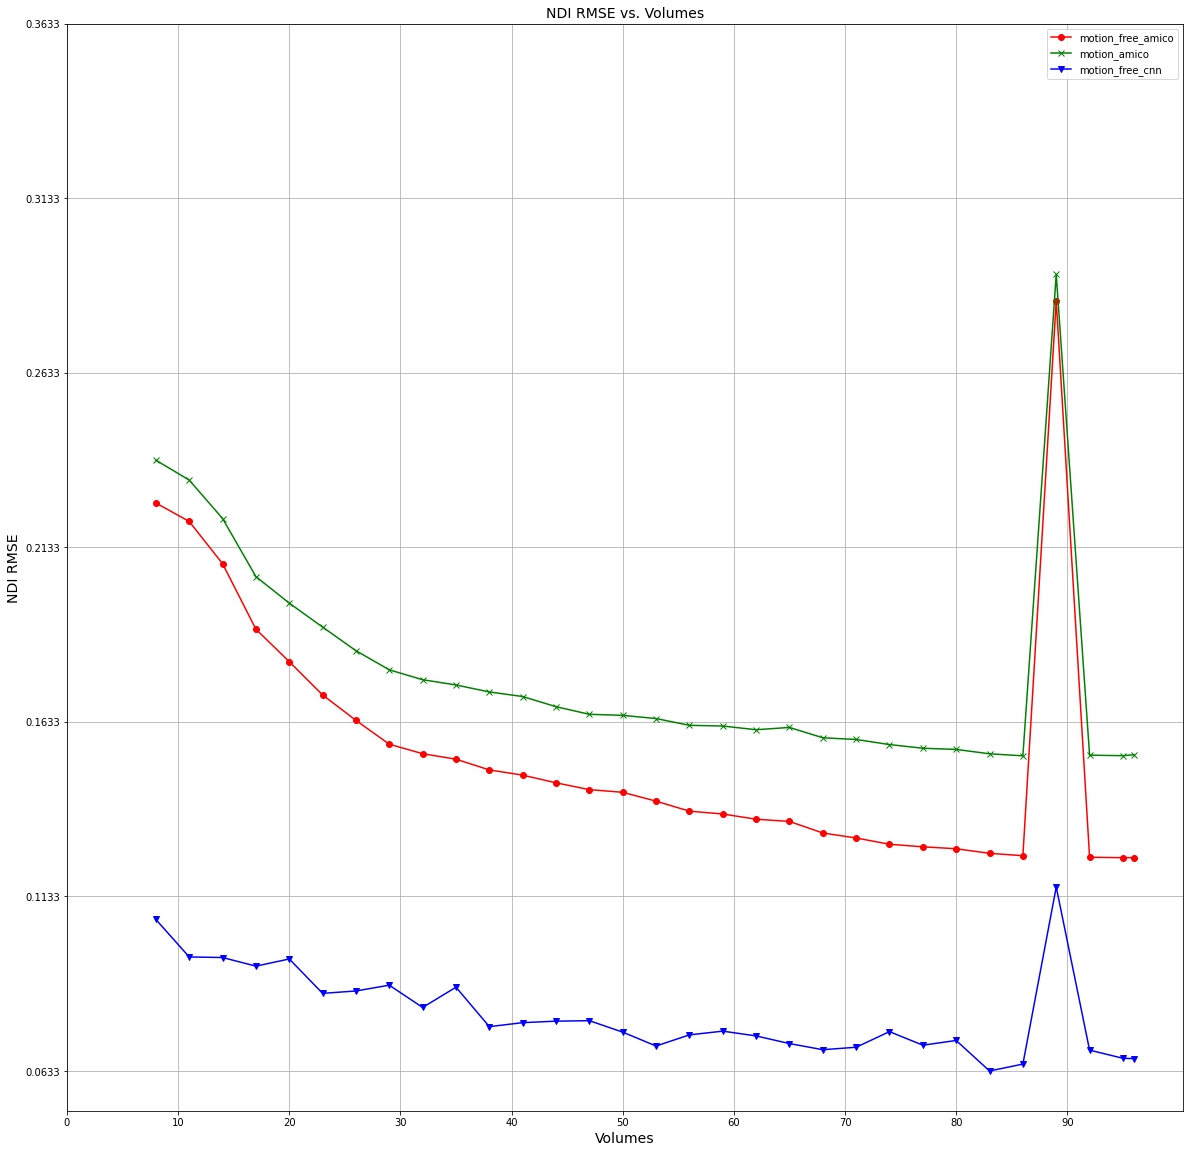

In [30]:
# plot graphs
plt.figure(figsize=(20,20))
plt.plot(volumes, motion_free_ami_ndi, color='red', marker='o') # motion-free ami is red 
plt.plot(volumes, motion_ami_ndi, color='green', marker='x') # motion ami is green
plt.plot(volumes, motion_cnn_ndi, color='blue', marker='v') # motion cnn is blue
plt.title('NDI RMSE vs. Volumes', fontsize=14)
plt.xlabel('Volumes', fontsize=14)
plt.xticks( range(0,100,10) )   # Put x axis ticks every 10 units.
plt.ylabel('NDI RMSE', fontsize=14)
plt.yticks(np.arange(min(motion_cnn_ndi), max(motion_ami_ndi)+0.1, 0.05))
plt.legend(['motion_free_amico', 'motion_amico', 'motion_free_cnn'], loc='upper right')
plt.grid(True)
# save picture
plt.savefig(os.path.join('/home/vw/Data/IndividualProject/MedICSS2021_/Net/new_exp1_results/s3', 'ndi_performance.jpg'))

--------

In [31]:
# ODI data value
motion_free_ami_odi = [x[1] for x in motion_free_rmse]
motion_ami_odi = [x[1] for x in motion_ami_rmse]
motion_cnn_odi = [x[1] for x in motion_cnn_rmse]

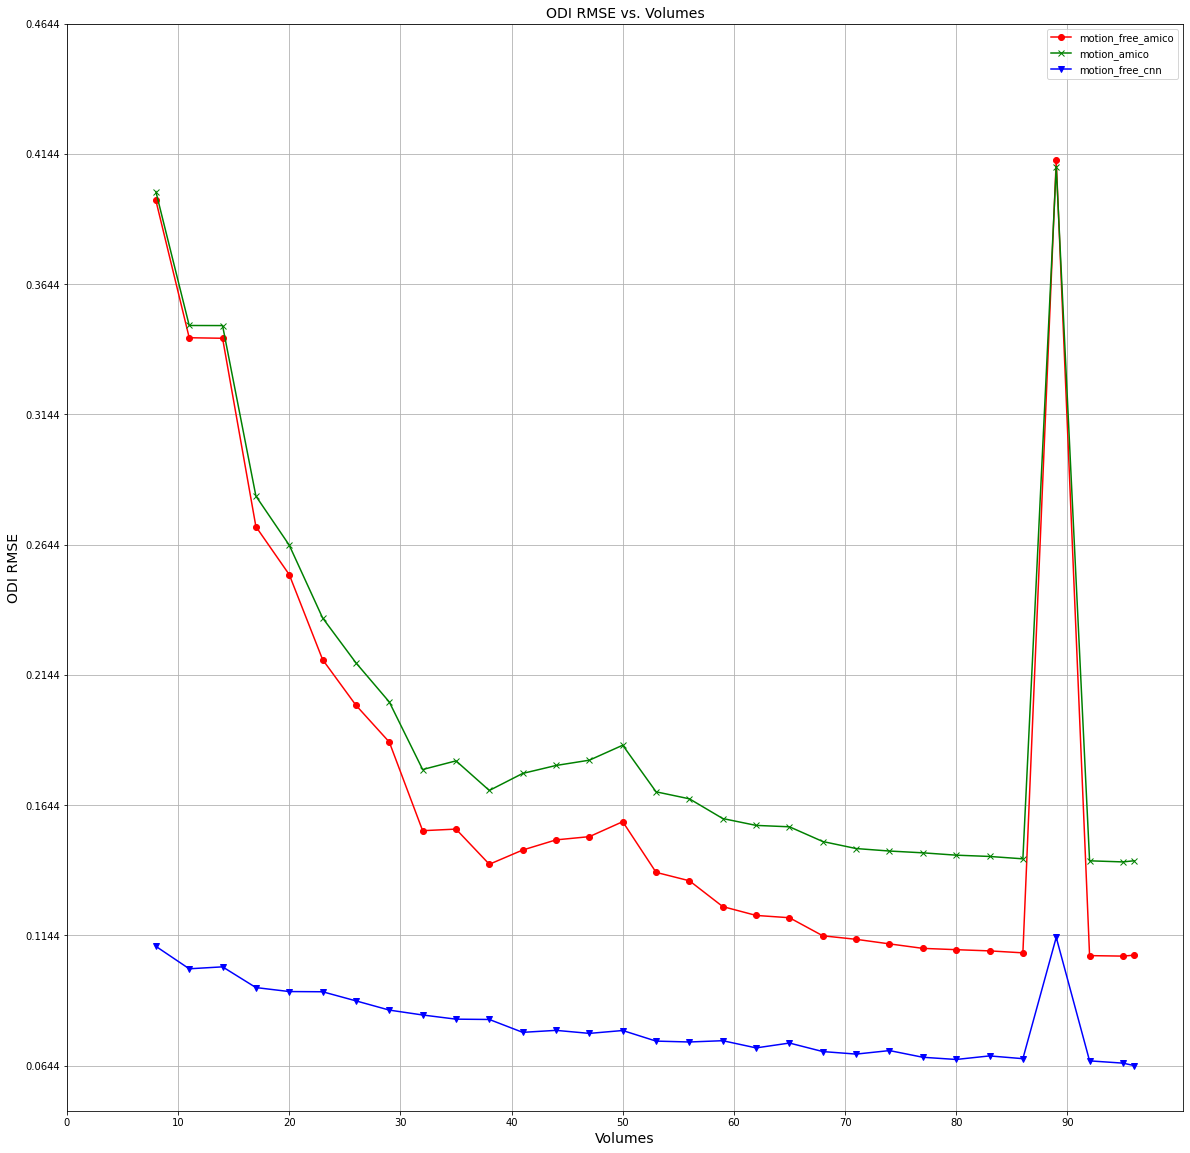

In [32]:
# plot graphs
plt.figure(figsize=(20,20))
plt.plot(volumes, motion_free_ami_odi, color='red', marker='o') # motion-free ami is red 
plt.plot(volumes, motion_ami_odi, color='green', marker='x') # motion ami is green
plt.plot(volumes, motion_cnn_odi, color='blue', marker='v') # motion cnn is blue
plt.title('ODI RMSE vs. Volumes', fontsize=14)
plt.xlabel('Volumes', fontsize=14)
plt.xticks( range(0,100,10) )   # Put x axis ticks every 10 units.
plt.ylabel('ODI RMSE', fontsize=14)
plt.yticks(np.arange(min(motion_cnn_odi), max(motion_ami_odi)+0.1, 0.05))
plt.legend(['motion_free_amico', 'motion_amico', 'motion_free_cnn'], loc='upper right')
plt.grid(True)
# save picture
plt.savefig(os.path.join('/home/vw/Data/IndividualProject/MedICSS2021_/Net/new_exp1_results/s3', 'odi_performance.jpg'),transparent=True)

-------------

In [33]:
# FWF data value
motion_free_ami_fwf = [x[2] for x in motion_free_rmse]
motion_ami_fwf = [x[2] for x in motion_ami_rmse]
motion_cnn_fwf = [x[2] for x in motion_cnn_rmse]

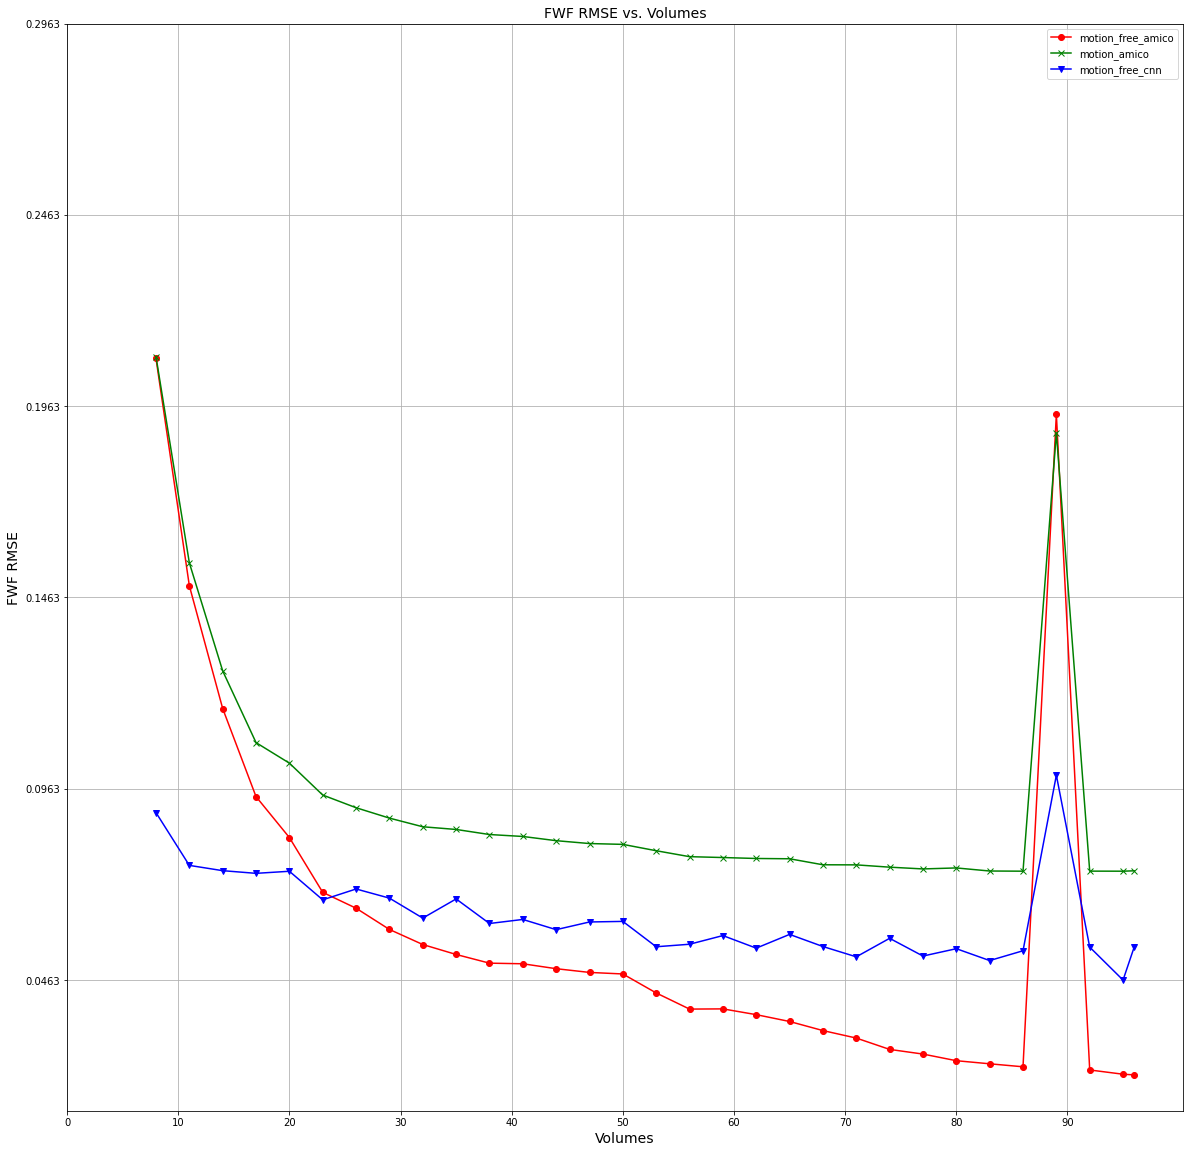

In [34]:
# plot graphs
plt.figure(figsize=(20,20))
plt.plot(volumes, motion_free_ami_fwf, color='red', marker='o') # motion-free ami is red 
plt.plot(volumes, motion_ami_fwf, color='green', marker='x') # motion ami is green
plt.plot(volumes, motion_cnn_fwf, color='blue', marker='v') # motion cnn is blue
plt.title('FWF RMSE vs. Volumes', fontsize=14)
plt.xlabel('Volumes', fontsize=14)
plt.xticks( range(0,100,10) )   # Put x axis ticks every 10 units.
plt.ylabel('FWF RMSE', fontsize=14)
plt.yticks(np.arange(min(motion_cnn_fwf), max(motion_ami_fwf)+0.1, 0.05))
plt.legend(['motion_free_amico', 'motion_amico', 'motion_free_cnn'], loc='upper right')
plt.grid(True)
# save picture
plt.savefig(os.path.join('/home/vw/Data/IndividualProject/MedICSS2021_/Net/new_exp1_results/s3', 'fwf_performance.jpg'),transparent=True)

---------------

In [35]:
# AVG data value
motion_free_ami_avg = [np.average(x) for x in motion_free_rmse]
motion_ami_avg = [np.average(x) for x in motion_ami_rmse]
motion_cnn_avg = [np.average(x) for x in motion_cnn_rmse]

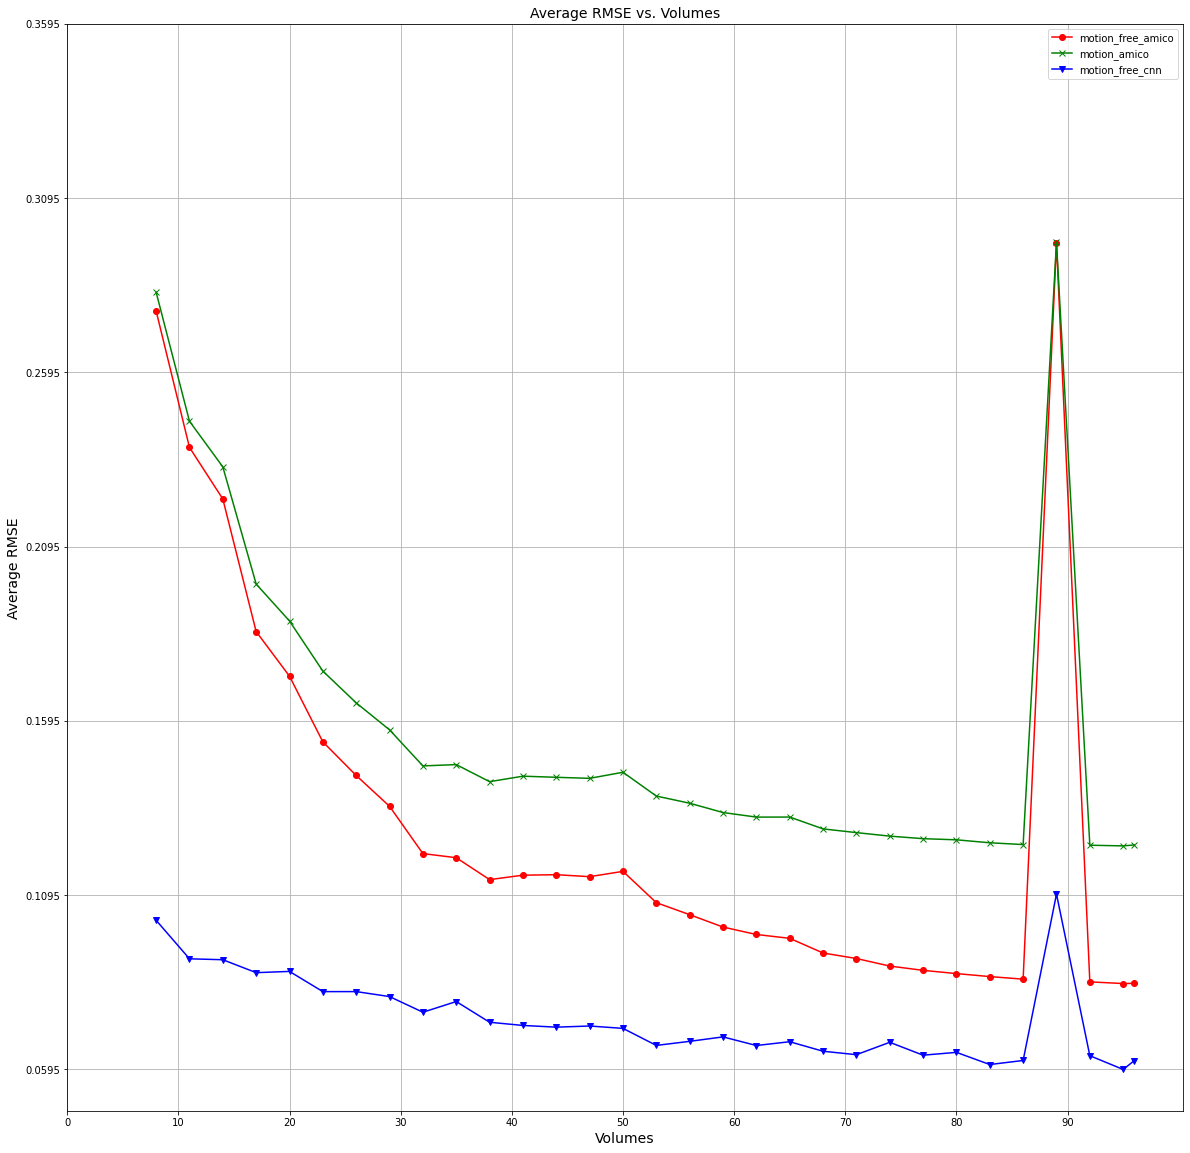

In [36]:
# plot graphs
plt.figure(figsize=(20,20))
plt.plot(volumes, motion_free_ami_avg, color='red', marker='o') # motion-free ami is red 
plt.plot(volumes, motion_ami_avg, color='green', marker='x') # motion ami is green
plt.plot(volumes, motion_cnn_avg, color='blue', marker='v') # motion cnn is blue
plt.title('Average RMSE vs. Volumes', fontsize=14)
plt.xlabel('Volumes', fontsize=14)
plt.xticks( range(0,100,10) )   # Put x axis ticks every 10 units.
plt.ylabel('Average RMSE', fontsize=14)
plt.yticks(np.arange(min(motion_cnn_avg), max(motion_ami_avg)+0.1, 0.05))
plt.legend(['motion_free_amico', 'motion_amico', 'motion_free_cnn'], loc='upper right')
plt.grid(True)
# save picture
plt.savefig(os.path.join('/home/vw/Data/IndividualProject/MedICSS2021_/Net/new_exp1_results/s3', 'avg_performance.jpg'),transparent=True)

In [9]:
bvals = '0 3000 1000 2000 2000 1000 2000 3000 1000 2000 3000 1000 2000 3000 1000 2000 3000 0 1000 3000 2000 1000 2000 3000 1000 2000 3000 1000 2000 3000 1000 2000 3000 0 1000 3000 2000 1000 1000 2000 3000 2000 3000 1000 2000 3000 1000 2000 3000 0 1000 2000 3000 1000 2000 3000 1000 2000 3000 1000 2000 3000 2000 1000 3000 0 1000 3000 2000 3000 1000 2000 1000 2000 3000 3000 1000 2000 1000 2000 3000 0 1000 3000 2000 1000 2000 2000 1000 3000 3000 1000 2000 3000 3000 1000'
bvals.split()[79]

'2000'

In [4]:
# use the stringnet threshold to filter off data
t0, t1, r0, r1, out, num = 3.0, 2.0, 3.0, 2.0, 0.05, 96

s03_motion_path = '/home/vw/Data/IndividualProject/MedICSS2021_/Data-NODDI/s03_motion'
filter_cmd = '--path ' + s03_motion_path + ' --t0 ' + str(t0) + ' --t1 ' + str(t1) + ' --r0 ' + str(r0) + ' --r1 ' + str(r1) + ' --out ' + str(out) + ' --num ' + str(num)
filter_args = filter_parser().parse_args(filter_cmd.split())
sorted_index = order_volumes(filter_args)
sorted_index

array([ 0, 33, 49, 50, 57, 60, 28, 26, 63, 65, 68, 70, 72, 39, 17, 18,  7,
        3,  4,  5,  6,  2,  8,  1, 10, 11, 12, 13,  9, 15, 14, 25, 62, 34,
       73, 27, 38, 47, 44, 40, 24, 20, 51, 41, 53, 71, 37, 86, 59, 43, 31,
       16, 22, 67, 46, 61, 66, 21, 19, 69, 87, 76, 45, 36, 29, 23, 42, 64,
       54, 77, 30, 58, 32, 48, 85, 52, 56, 78, 75, 91, 94, 95, 82, 84, 81,
       92, 74, 79, 83, 89, 90, 93, 35, 80, 88, 55])

In [5]:
sorted_index[87]

79